In [1]:
# Import necessary libraries
import os
import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader
from collections import OrderedDict
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import logging

from torch_brain.data import Dataset, collate
from torch_brain.data.sampler import RandomFixedWindowSampler
from torch_brain.models.capoyo import CaPOYO, CaPOYOTokenizer
from torch_brain.transforms import Compose
from torch_brain.utils import seed_everything
from torch_brain.utils import seed_everything, train_wrapper
from brainsets.taxonomy import decoder_registry

from tqdm import tqdm

In [2]:
# Set the environment variables and paths
ckpt_path = "/home/mila/x/xuejing.pan/POYO/last.ckpt"
data_root = "/home/mila/x/xuejing.pan/scratch"
config_path = "./configs/train_model_0_dg.yaml"

In [3]:

# Initialize Hydra with the config directory
initialize(config_path="./configs")
cfg = compose(config_name="train_model_0_dg")

seed_everything(cfg.seed)

# Higher speed on machines with tensor cores.
torch.set_float32_matmul_precision("medium")

log = logging.getLogger(__name__)

# Initialize model
model = hydra.utils.instantiate(
    cfg.model,
    decoder_specs=decoder_registry,
    _convert_="object",
)

# Prepare tokenizer and transforms
sequence_length = 1

tokenizer = CaPOYOTokenizer(
    model.unit_emb.tokenizer,
    model.session_emb.tokenizer,
    decoder_registry=decoder_registry,
    dim=model.dim_input,
    patch_size=model.patch_size,
    latent_step=cfg.get("latent_step", 1.0 / 8.0),
    num_latents_per_step=cfg.model.num_latents,
    batch_type=model.batch_type,
)

# Load datasets
train_dataset = Dataset(
    data_root,
    "train",
    include=OmegaConf.to_container(cfg.dataset),
    transform=tokenizer,
)
train_dataset.disable_data_leakage_check()

train_sampler = RandomFixedWindowSampler(
    interval_dict=train_dataset.get_sampling_intervals(),
    window_length=sequence_length,
    generator=torch.Generator().manual_seed(cfg.seed + 1),
)

#train_sampler = SequentialSampler(train_dataset)

train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    collate_fn=collate,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    drop_last=True,
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False,
    prefetch_factor=2 if cfg.num_workers > 0 else None,
)

/tmp/ipykernel_1928684/2167773324.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="./configs")


In [4]:
# Function to load model from checkpoint
def load_model_from_ckpt(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt["state_dict"]
    new_state_dict = OrderedDict()

    for key in state_dict.keys():
        new_key = key.removeprefix("model.")
        new_state_dict[new_key] = state_dict[key]
    # del new_state_dict["readout.projections.NATURAL_MOVIE_FRAME.weight"]
    # del new_state_dict["readout.projections.NATURAL_MOVIE_FRAME.bias"]
    model.load_state_dict(new_state_dict, strict=False)
    return model

model = load_model_from_ckpt(model, ckpt_path)
wrapper = model


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CaPOYO(
  (unit_emb): InfiniteVocabEmbedding(embedding_dim=64, num_embeddings=119858)
  (token_type_emb): Embedding(4, 64)
  (value_embedding_layer): Linear(in_features=1, out_features=64, bias=False)
  (latent_emb): Embedding(16, 64)
  (session_emb): InfiniteVocabEmbedding(embedding_dim=64, num_embeddings=1336)
  (task_emb): Embedding(35, 64)
  (perceiver_io): PerceiverRotary(
    (rotary_emb): RotaryEmbedding()
    (dropout): Dropout(p=0.4, inplace=False)
    (enc_atn): RotaryCrossAttention(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_context): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (to_q): Linear(in_features=64, out_features=128, bias=False)
      (to_kv): Linear(in_features=128, out_features=256, bias=False)
      (to_out): Linear(in_features=128, out_features=64, bias=True)
    )
    (enc_ffn): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): FeedForward(
        (net): Sequential(
      

## Extracting latents in forward pass

In [6]:
total_batches = len(train_loader)

print(total_batches)

3459


In [7]:
progress_bar = tqdm(train_loader, desc="Extracting latent")
count = 0
# Initialize a list to collect output_latents
# Initialize lists for all collected data
all_output_latents, session_id_all, creline_all, area_all, depth_all = [], [], [], [], []

# Use list comprehensions for efficient batch extraction
# Use list comprehensions for efficient batch extraction
for idx, batch in enumerate(progress_bar):
    # If the current batch index is not in the random selection, skip it
    #if idx not in random_indices:
    #    continue

    batch = {key: value.to(device) if torch.is_tensor(value) else value for key, value in batch.items()}

    # Extract batch data and labels
    curr_sess_ids = batch['session_index'].cpu().numpy()[:,0]
    curr_crelines = batch['unit_cre_line'].cpu().numpy()[:, 0]
    curr_area = batch['target_area'].cpu().numpy()[:, 0]
    curr_depth = batch['unit_depth'].cpu().numpy()[:, 0]

    session_id_all.append(curr_sess_ids)
    creline_all.append(curr_crelines)
    area_all.append(curr_area)
    depth_all.append(curr_depth)

    # Ensure targets are on the correct device
    for key in ['output_values', 'output_weights']:
        if key in batch:
            batch[key] = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch[key].items()}
    
    # Forward pass through the model
    outputs, _, _, output_latents = model(**batch)
    output_latents = output_latents.view(128, -1).detach().cpu().numpy()
    all_output_latents.append(output_latents)

    count += 1

# Concatenate all collected data efficiently
concat = lambda x: np.concatenate(x, axis=0)
latents_all = concat(all_output_latents)
session_id_all, creline_all, area_all, depth_all = map(concat, [session_id_all, creline_all, area_all, depth_all])

Extracting latent: 100%|██████████| 3459/3459 [20:17<00:00,  2.84it/s]  


In [8]:
np.savez('/home/mila/x/xuejing.pan/scratch/latents/output_latents_dg(multi_task).npz', latents_all=latents_all , session_id_all=session_id_all, creline_all=creline_all,area_all=area_all,depth_all=depth_all)

## Loading latents and processing

In [1]:
import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 16        # Global font size
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 18   # Axis label font size
plt.rcParams['xtick.labelsize'] = 18  # X-tick label font size
plt.rcParams['ytick.labelsize'] = 22  # Y-tick label font size
plt.rcParams['legend.fontsize'] = 14  # Legend font size
plt.rcParams['lines.linewidth'] = 4.5
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#662E7D'])


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler


In [3]:
data = np.load('/home/mila/x/xuejing.pan/scratch/latents/output_latents_dg(multi_task).npz')

# Extract the numpy array
all_latents = data['latents_all']
session_id_all = data['session_id_all']
creline_all = data['creline_all']
area_all = data['area_all']
depth_all = data['depth_all']

del data

In [4]:
scaler = StandardScaler()
normalized_all_latents = scaler.fit_transform(all_latents)

In [5]:

# Define the bin edges for the depth ranges
bins = [0, 250, 350, 500, np.inf]

# Map the values of depth_all to the corresponding integer classes
# 0 -> L2/3, 1 -> L4, 2 -> L5, 3 -> L6
depth_all_classes = np.digitize(depth_all, bins) - 1  # digitize returns bin indices starting from 1


## Dendrogram

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [7]:
creline_map = {
    0: "Cux2",
    1: "Exm1",
    2: "Fezf2",
    3: "Nr5a1",
    4: "Ntsr1",
    5: "Pvalb",
    6: "Rbp4",
    7: "Rorb",
    8: "Scnn1a",
    9: "Slc17a7",
    10: "Sst",
    11: "Tlx3",
    12: "Vip"
}

# Create a dictionary to map integer classes to string labels
depth_map = {0: "L2/3", 1: "L4", 2: "L5", 3: "L6"}

area_map = {
    0: "RL", 
    1: "PM",
    2: "AL",
    3: "AM",
    4: "P",
    5: "L"
}


In [8]:

# Dictionary to store the average latents for each creline and depth combination
average_latents = {}

# Get unique creline values
unique_crelines = np.unique(creline_all)

# Loop through each creline
for creline in unique_crelines:
    # Get the indices for this creline
    creline_indices = np.where(creline_all == creline)[0]
    
    # If creline == 1 or creline == 9, further divide based on depth
    if creline == 1 or creline == 9:
        unique_depths = np.unique(depth_all_classes[creline_indices])
        for depth in unique_depths:
            depth_indices = creline_indices[depth_all_classes[creline_indices] == depth]
            avg_latent = np.mean(all_latents[depth_indices], axis=0)
            average_latents[(creline, depth)] = avg_latent
    else:
        # For other crelines, calculate the average directly
        avg_latent = np.mean(all_latents[creline_indices], axis=0)
        average_latents[creline] = avg_latent

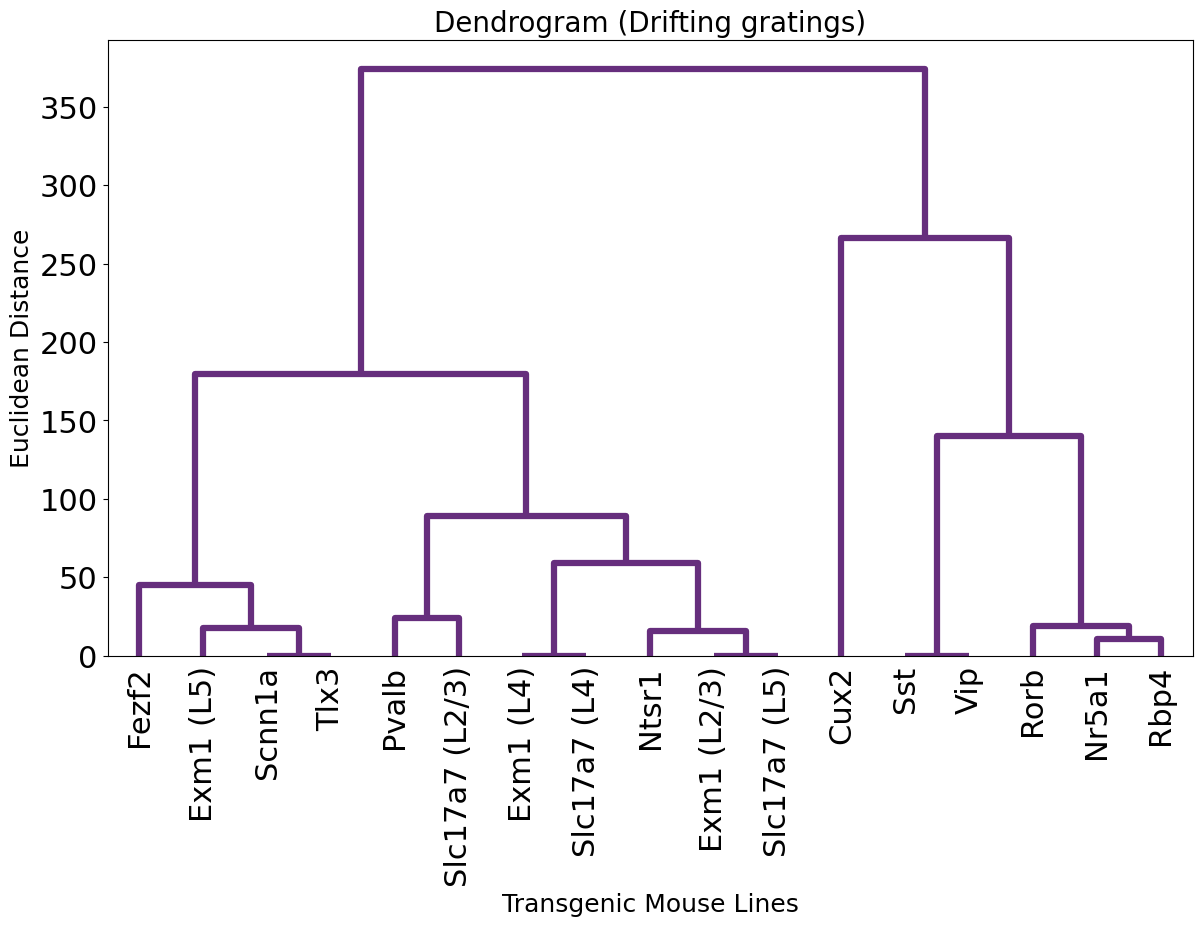

In [11]:
# Assuming `average_latents` is your dictionary with creline (or creline, depth) as keys and average latents as values
keys = list(average_latents.keys())
avg_latent_values = np.array([average_latents[key] for key in keys])

# Replace creline and depth values in the keys with the corresponding names from creline_map and depth_map
def format_label(key):
    if isinstance(key, tuple):  # For (creline, depth) keys
        creline_label = creline_map[key[0]]
        depth_label = depth_map[key[1]]
        return f"{creline_label} ({depth_label})"
    else:  # For single creline keys
        return creline_map[key]

# Apply the label formatting function to all keys
formatted_labels = [format_label(key) for key in keys]

# Step 1: Standardize the data
scaler = StandardScaler()
avg_latent_scaled = scaler.fit_transform(avg_latent_values)

# Step 2: Perform hierarchical clustering using the linkage function
Z = linkage(avg_latent_scaled, method='ward')

# Step 3: Plot the dendrogram with the new labels
plt.figure(figsize=(14, 8))
dendrogram(Z, labels=formatted_labels, leaf_rotation=90, leaf_font_size=22, show_leaf_counts=True,)#  above_threshold_color='#F9B40D')
plt.title('Dendrogram (Drifting gratings)')
plt.xlabel('Transgenic Mouse Lines')
plt.ylabel('Euclidean Distance')
plt.show()